# <b></span><span style='color:#87CEEB'> Importing Necessary Libraries</span></b>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# <b></span><span style='color:#87CEEB'> Load dataware house</span></b>

In [27]:
df_flights = pd.read_csv('viagens/flights_ratings_modelos.csv')

In [28]:
colunas_dataset = ["FL_DATE", "AIRLINE_CODE", "FL_NUMBER","ORIGIN","DEST","DEP_TIME","CRS_DEP_TIME","CRS_ARR_TIME",
                   "ARR_TIME","CANCELLED","DIVERTED","DISTANCE","DELAY_DUE_CARRIER","DELAY_DUE_WEATHER","DELAY_DUE_NAS",
                   "DELAY_DUE_SECURITY","DELAY_DUE_LATE_AIRCRAFT", "Rating", "Modelo Avião"]

In [47]:
df_flights = df_flights[colunas_dataset]

# <b></span><span style='color:#87CEEB'> Initial Data Analysis</span></b>

In [48]:
df_flights.head(10)

,FL_DATE,AIRLINE_CODE,FL_NUMBER,ORIGIN,DEST,DEP_TIME,CRS_DEP_TIME,CRS_ARR_TIME,ARR_TIME,CANCELLED,DIVERTED,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,Rating,Modelo Avião
0,2019-01-09,UA,1562,FLL,EWR,1151.0,1155,1501,1447.0,0.0,0.0,1065.0,NaN,NaN,NaN,NaN,NaN,2.4,Airbus A320
1,2022-11-19,DL,1149,MSP,SEA,2114.0,2120,2315,2310.0,0.0,0.0,1399.0,NaN,NaN,NaN,NaN,NaN,7.1,Airbus A300
2,2022-07-22,UA,459,DEN,MSP,1000.0,954,1252,1252.0,0.0,0.0,680.0,NaN,NaN,NaN,NaN,NaN,4.2,Airbus A340
3,2023-03-06,DL,2295,MSP,SFO,1608.0,1609,1829,1853.0,0.0,0.0,1589.0,0.0,0.0,24.0,0.0,0.0,3.3,Boeing 767-200
4,2020-02-23,NK,407,MCO,DFW,1838.0,1840,2041,2040.0,0.0,0.0,985.0,NaN,NaN,NaN,NaN,NaN,0.5,Airbus A330-200
5,2019-07-31,WN,665,DAL,OKC,1237.0,1010,1110,1331.0,0.0,0.0,181.0,141.0,0.0,0.0,0.0,0.0,4.8,Boeing 747-400
6,2023-06-11,AA,2134,DCA,BOS,1001.0,1010,1159,1130.0,0.0,0.0,399.0,NaN,NaN,NaN,NaN,NaN,5.5,Boeing 787-10
7,2019-07-08,YX,4464,HSV,DCA,1637.0,1643,1945,2008.0,0.0,0.0,613.0,0.0,0.0,23.0,0.0,0.0,3.3,Boeing 727
8,2023-02-12,NK,590,IAH,LAX,527.0,530,717,706.0,0.0,0.0,1379.0,NaN,NaN,NaN,NaN,NaN,2.2,Airbus A330
9,2020-08-22,AS,223,SEA,FAI,2116.0,2125,2355,2356.0,0.0,0.0,1533.0,NaN,NaN,NaN,NaN,NaN,1.8,Airbus A330-200


In [49]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 19 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   FL_DATE                  object 
 1   AIRLINE_CODE             object 
 2   FL_NUMBER                int64  
 3   ORIGIN                   object 
 4   DEST                     object 
 5   DEP_TIME                 float64
 6   CRS_DEP_TIME             int64  
 7   CRS_ARR_TIME             int64  
 8   ARR_TIME                 float64
 9   CANCELLED                float64
 10  DIVERTED                 float64
 11  DISTANCE                 float64
 12  DELAY_DUE_CARRIER        float64
 13  DELAY_DUE_WEATHER        float64
 14  DELAY_DUE_NAS            float64
 15  DELAY_DUE_SECURITY       float64
 16  DELAY_DUE_LATE_AIRCRAFT  float64
 17  Rating                   float64
 18  Modelo Avião             object 
dtypes: float64(11), int64(3), object(5)
memory usage: 434.9+ MB


In [50]:
# Summary statistics for numerical variables
df_flights.describe().T

,count,mean,std,min,25%,50%,75%,max
FL_NUMBER,3000000.0,2511.535519,1747.258040,1.0,1051.0,2152.0,3797.0,9562.0
DEP_TIME,2922385.0,1329.775913,499.310052,1.0,916.0,1323.0,1739.0,2400.0
CRS_DEP_TIME,3000000.0,1327.061984,485.878854,1.0,915.0,1320.0,1730.0,2359.0
CRS_ARR_TIME,3000000.0,1490.560665,511.547566,1.0,1107.0,1516.0,1919.0,2400.0
ARR_TIME,2920058.0,1466.511162,531.838349,1.0,1053.0,1505.0,1913.0,2400.0
CANCELLED,3000000.0,0.026380,0.160263,0.0,0.0,0.0,0.0,1.0
DIVERTED,3000000.0,0.002352,0.048440,0.0,0.0,0.0,0.0,1.0
DISTANCE,3000000.0,809.361552,587.893938,29.0,377.0,651.0,1046.0,5812.0
DELAY_DUE_CARRIER,533863.0,24.759086,71.771845,0.0,0.0,4.0,23.0,2934.0
DELAY_DUE_WEATHER,533863.0,3.985260,32.410796,0.0,0.0,0.0,0.0,1653.0


In [51]:
# Summary statistics for categorical variables
df_flights.describe(include='object').T

,count,unique,top,freq
FL_DATE,3000000,1704,2019-07-25,2379
AIRLINE_CODE,3000000,18,WN,576470
ORIGIN,3000000,380,ATL,153556
DEST,3000000,380,ATL,153569
Modelo Avião,3000000,105,Boeing 737-300,39478


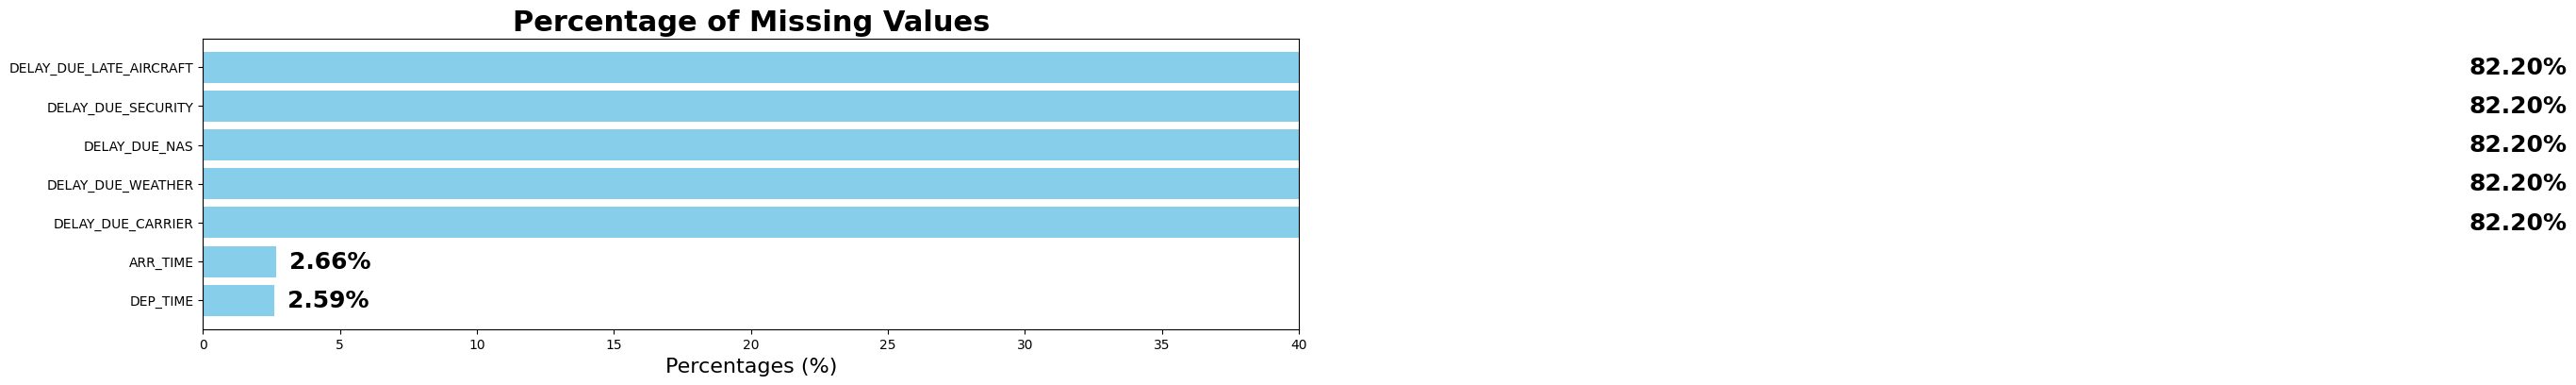

In [52]:
# Calculating the percentage of missing values for each column
missing_data = df_flights.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df_flights.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#87CEEB')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [53]:
df_flights_clean = df_flights.dropna(subset=["ARR_TIME","DEP_TIME"]).copy()

In [54]:
def hhmm_to_minutes(hhmm):
    # Converter valores nulos ou inválidos
    try:
        hhmm = int(hhmm)
        hours = hhmm // 100
        minutes = hhmm % 100
        return hours * 60 + minutes
    except:
        return None

# Converter os tempos para minutos
df_flights_clean.loc[:, "DEP_TIME_MIN"] =  df_flights_clean["DEP_TIME"].apply(hhmm_to_minutes)
df_flights_clean.loc[:, "CRS_DEP_TIME_MIN"] =  df_flights_clean["CRS_DEP_TIME"].apply(hhmm_to_minutes)
df_flights_clean.loc[:, "ARR_TIME_MIN"] =  df_flights_clean["ARR_TIME"].apply(hhmm_to_minutes)
df_flights_clean.loc[:, "CRS_ARR_TIME_MIN"] =  df_flights_clean["CRS_ARR_TIME"].apply(hhmm_to_minutes)

#for col in ["DEP_TIME", "CRS_DEP_TIME", "ARR_TIME", "CRS_ARR_TIME"]:
#    df_flights_clean[col + "_MIN"] = df_flights_clean[col].apply(hhmm_to_minutes)

# Calcular o TOTAL_DELAY
df_flights_clean["DEP_DELAY"] = (
    df_flights_clean["DEP_TIME_MIN"] - df_flights_clean["CRS_DEP_TIME_MIN"]
)

df_flights_clean["ARR_DELAY"] = (
    df_flights_clean["ARR_TIME_MIN"] - df_flights_clean["CRS_ARR_TIME_MIN"]
)


In [55]:
df_flights_clean.head(10)

,FL_DATE,AIRLINE_CODE,FL_NUMBER,ORIGIN,DEST,DEP_TIME,CRS_DEP_TIME,CRS_ARR_TIME,ARR_TIME,CANCELLED,...,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,Rating,Modelo Avião,DEP_TIME_MIN,CRS_DEP_TIME_MIN,ARR_TIME_MIN,CRS_ARR_TIME_MIN,DEP_DELAY,ARR_DELAY
0,2019-01-09,UA,1562,FLL,EWR,1151.0,1155,1501,1447.0,0.0,...,NaN,NaN,2.4,Airbus A320,711,715,887,901,-4,-14
1,2022-11-19,DL,1149,MSP,SEA,2114.0,2120,2315,2310.0,0.0,...,NaN,NaN,7.1,Airbus A300,1274,1280,1390,1395,-6,-5
2,2022-07-22,UA,459,DEN,MSP,1000.0,954,1252,1252.0,0.0,...,NaN,NaN,4.2,Airbus A340,600,594,772,772,6,0
3,2023-03-06,DL,2295,MSP,SFO,1608.0,1609,1829,1853.0,0.0,...,0.0,0.0,3.3,Boeing 767-200,968,969,1133,1109,-1,24
4,2020-02-23,NK,407,MCO,DFW,1838.0,1840,2041,2040.0,0.0,...,NaN,NaN,0.5,Airbus A330-200,1118,1120,1240,1241,-2,-1
5,2019-07-31,WN,665,DAL,OKC,1237.0,1010,1110,1331.0,0.0,...,0.0,0.0,4.8,Boeing 747-400,757,610,811,670,147,141
6,2023-06-11,AA,2134,DCA,BOS,1001.0,1010,1159,1130.0,0.0,...,NaN,NaN,5.5,Boeing 787-10,601,610,690,719,-9,-29
7,2019-07-08,YX,4464,HSV,DCA,1637.0,1643,1945,2008.0,0.0,...,0.0,0.0,3.3,Boeing 727,997,1003,1208,1185,-6,23
8,2023-02-12,NK,590,IAH,LAX,527.0,530,717,706.0,0.0,...,NaN,NaN,2.2,Airbus A330,327,330,426,437,-3,-11
9,2020-08-22,AS,223,SEA,FAI,2116.0,2125,2355,2356.0,0.0,...,NaN,NaN,1.8,Airbus A330-200,1276,1285,1436,1435,-9,1
